# **This was my first sentiment analysis here on Kaggle, feel free to criticize**

---

## Imports
---

In [273]:
import pandas as pd
import re
from unidecode import unidecode
import nltk
from nltk.corpus import stopwords
#nltk.download('stopwords')
from nltk.classify import NaiveBayesClassifier
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *

import seaborn as sns
import matplotlib.pyplot as plt
import collections
from wordcloud import WordCloud

## Data
---

In [274]:
df = pd.read_excel('data/LabeledText.xlsx')

In [275]:
df.head()

,File Name,Caption,LABEL
0,1.txt,How I feel today #legday #jelly #aching #gym,negative
1,10.txt,@ArrivaTW absolute disgrace two carriages from...,negative
2,100.txt,This is my Valentine's from 1 of my nephews. I...,positive
3,1000.txt,betterfeelingfilms: RT via Instagram: First da...,neutral
4,1001.txt,Zoe's first love #Rattled @JohnnyHarper15,positive


## Data processing
---

In [276]:
df.drop('File Name', axis = 1, inplace = True)

In [277]:
regex = re.compile('[^a-zA-Z\s]')

df['CleanCaption'] = df['Caption'].apply(lambda x: regex.sub('', x)) # remo
df['CleanCaption'] = df['CleanCaption'].apply(lambda x: regex.sub('', unidecode(x)))
df['CleanCaption'] = df['CleanCaption'].str.lower()
df['CleanCaption'] = df['CleanCaption'].str.replace('rt|http', '', regex = True)
df['CleanCaption'] = df['CleanCaption'].apply(lambda x: ' '.join([w for w in x.split() if len(w) > 2]))

In [278]:
df.rename(columns = {'LABEL' : 'Label'}, inplace = True)

## StopWords
---

In [279]:
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    tokens = text.split()
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text

df['CleanCaption'] = df['CleanCaption'].apply(lambda x: remove_stopwords(x))

In [280]:
df.head()

,Caption,Label,CleanCaption
0,How I feel today #legday #jelly #aching #gym,negative,feel today legday jelly aching gym
1,@ArrivaTW absolute disgrace two carriages from...,negative,arrivatw absolute disgrace two carriages bango...
2,This is my Valentine's from 1 of my nephews. I...,positive,valentines nephews elated sometimes little thi...
3,betterfeelingfilms: RT via Instagram: First da...,neutral,betterfeelingfilms via instagram first day fil...
4,Zoe's first love #Rattled @JohnnyHarper15,positive,zoes first love rattled johnnyharper


## Visualization
---

<AxesSubplot:xlabel='Label', ylabel='count'>

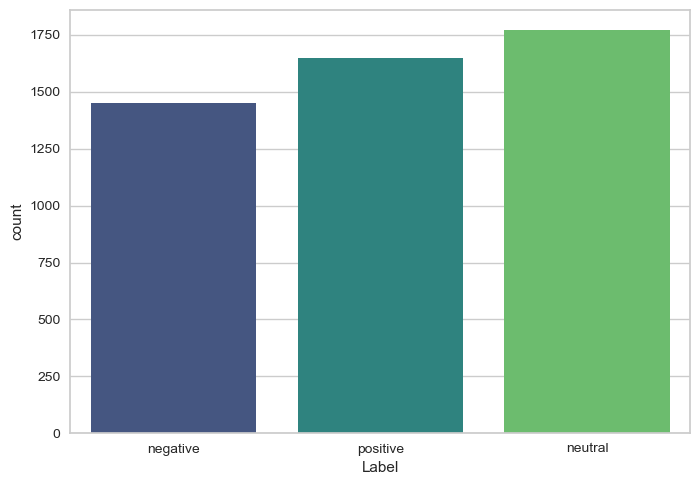

In [281]:
sns.countplot(x = df['Label'], palette = 'viridis')

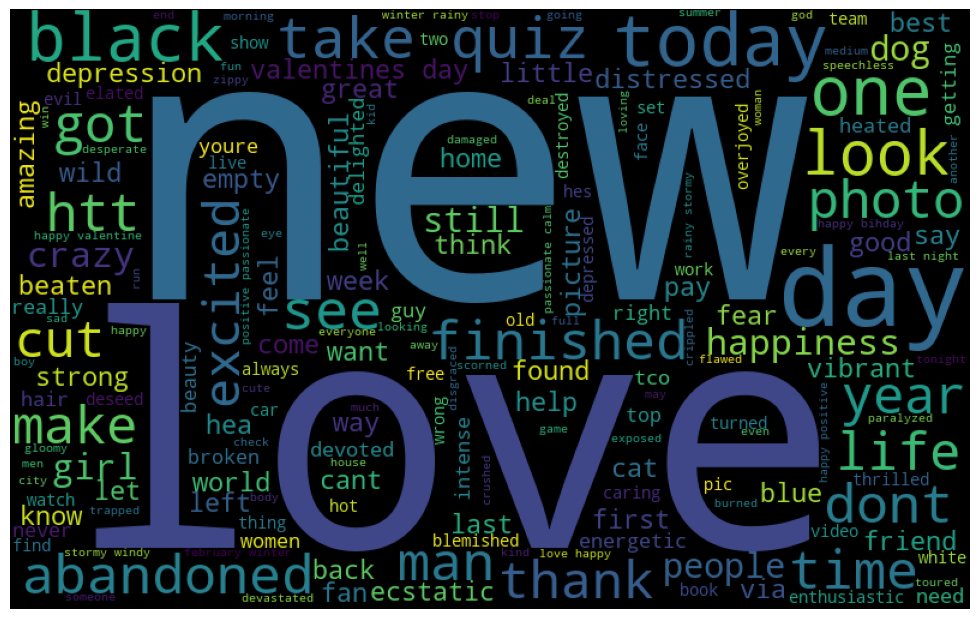

In [282]:
text = " ".join(caption for caption in df['CleanCaption'])

wordcloud = WordCloud(width = 800, height = 500, background_color = 'black', 
                min_font_size = 10).generate(text)

plt.figure(figsize = (10, 6), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

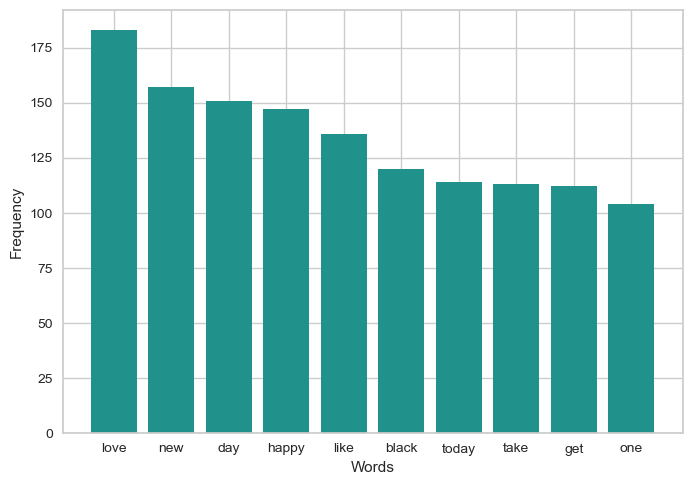

In [283]:
words = []
for text in df['CleanCaption']:
    words.extend(text.split())
word_count = collections.Counter(words)
top_words = dict(word_count.most_common(10))

colors = plt.cm.viridis([0.5]*len(top_words))

plt.bar(range(len(top_words)), list(top_words.values()), align = 'center', color = colors)
plt.xticks(range(len(top_words)), list(top_words.keys()))
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.show()

## Train/Test
---

In [284]:
train_size = int(len(df) * 0.8)
train_data = df[:train_size]
test_data = df[train_size:]

## Extracting relevant features from the data
---

In [285]:
def extract_features(text):
    words = set(text.split())
    features = {}
    for word in words:
        features[word] = text.count(word)
    return features

train_features = [(extract_features(text), label) for text, label in zip(train_data['CleanCaption'], train_data['Label'])]
test_features = [(extract_features(text), label) for text, label in zip(test_data['CleanCaption'], test_data['Label'])]

## Metrics
---

In [286]:
classifier = NaiveBayesClassifier.train(train_features)

print('Accuracy:', nltk.classify.accuracy(classifier, test_features))

Accuracy: 0.6858316221765913


In [287]:
from sklearn.metrics import classification_report

y_pred = [classifier.classify(features) for features, label in test_features]

target_names = ['negative', 'neutral', 'positive']
print(classification_report(test_data['Label'], y_pred, target_names = target_names))

              precision    recall  f1-score   support

    negative       0.64      0.71      0.67       257
     neutral       0.78      0.50      0.61       385
    positive       0.66      0.88      0.76       332

    accuracy                           0.69       974
   macro avg       0.69      0.70      0.68       974
weighted avg       0.70      0.69      0.68       974



_